In [4]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
from math import cos, pi

In [5]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
#ground_material = nmm.Material.from_library("concrete_heavy").openmc_material
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

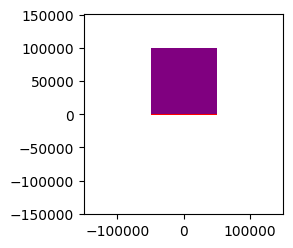

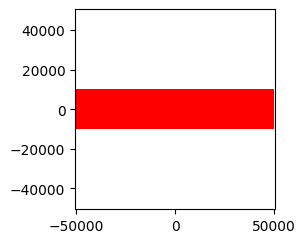

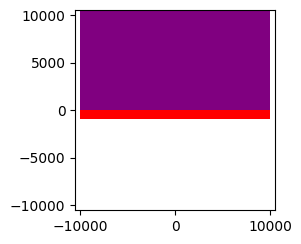

In [6]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, 0, 100000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -10000, 10000, -1000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-50001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-10001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(300100, 301100), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(101100, 101100), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='yz', colors=color_assignment))

In [7]:
def sim_sett(theta):
    #create the source
    sett = openmc.Settings()
    sett.particles = 500000
    sett.batches = 4
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    source = openmc.Source()
    source.particle = 'neutron'
    source.energy = openmc.stats.Discrete([10e6], [1])

    mu = openmc.stats.Uniform(cos(theta), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
    source.space = openmc.stats.Point((0,0,5000))
    sett.source = source
    sett.export_to_xml()
    return sett

In [8]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [100,1,1]
air_mesh.lower_left = [-50000,-10000, 0]

air_mesh.upper_right = [50000,10000, 100]
mesh_filter = openmc.MeshFilter(air_mesh)

In [9]:
#tally
def create_tally():
    tallies = openmc.Tallies()
    shine_tally = openmc.Tally(name='shine_tally')
    neutron_filter = openmc.ParticleFilter(['neutron'])
    shine_tally.scores  = ['flux']
    shine_tally.filters = [mesh_filter, neutron_filter]
    tallies.append(shine_tally)
    tallies.export_to_xml()
    return tallies

In [10]:
angles = np.array([20, 25, 27.7585, 30, 35, 40])
angles

array([20.    , 25.    , 27.7585, 30.    , 35.    , 40.    ])

In [12]:


df_list = []
for angle in angles:
    settings = sim_sett(angle)
    sim_tallies = create_tally()
    print(angle)
    model = openmc.model.Model(geom, mats, settings, sim_tallies)
    !rm *.h5
    results_filename = model.run()
    
    results = openmc.StatePoint(results_filename)
    flux_tally = results.get_tally(name="shine_tally")
    df = flux_tally.get_pandas_dataframe()
    df_list.append(df)
    results.close()

20.0
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 ################

In [15]:
distance_x = air_mesh.vertices[:,0,0,0]
for i, angle in enumerate(angles):
    df_list[i]["Angles"] = angle

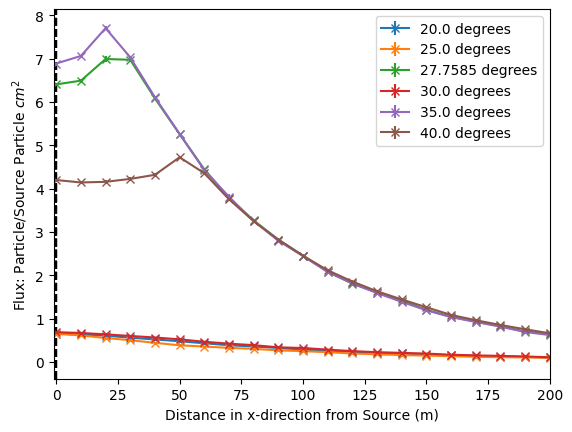

In [16]:
for df in df_list[:]:
    flux = df[df['score'] == 'flux']
    flux_mean = flux["mean"]
    flux_std = flux["std. dev."]
    plt.errorbar(distance_x[:-1]/100, flux_mean, flux_std, label=(str(df["Angles"][0])+ " degrees"), marker='x')
    plt.legend()
    plt.xlabel("Distance in x-direction from Source (m)")
    plt.ylabel("Flux: Particle/Source Particle $cm^2$")
    plt.axvline(x=0, ls='--', color='black')
    plt.xlim(-1,200)
    #plt.ylim(3,8.5)
    #plt.xscale('log')
    #plt.yscale('log')

In [ ]:
#plot flux as function of energy
flux_array = np.array(flux_list)
flux_array
np.max(df_list[0]["mean"])

In [ ]:
flux_array[:,50]

In [ ]:
plt.loglog(energies, flux_array, color='b', ls=None, marker='x')
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux p/sp cm2")
plt.title("Flux as function of energy of neutron for peak fluence")